In [2]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook


# Saving models
import pickle

# Reading the tweets

In [7]:
df = pd.read_csv('2020-03-29 Coronavirus Tweets.CSV')
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1244051646071611394,860252856829587457,2020-03-29T00:00:00Z,IMSS_SanLuis,"Ante cualquier enfermedad respiratoria, no te ...",TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,1008,41,NaN,2017-05-04T22:00:38Z,False,es
1,1244051645039706112,1125933654943895553,2020-03-29T00:00:00Z,intrac_ccs,#ATENCIÓN En el Terminal Nuevo Circo se implem...,TweetDeck,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,90,316,NaN,2019-05-08T01:21:16Z,False,es
2,1244051645975191557,80943559,2020-03-29T00:00:00Z,rlieving,“People are just storing up. They are staying ...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,136,457,NaN,2009-10-08T21:06:08Z,False,en
3,1244051646750928897,817072420947247104,2020-03-29T00:00:00Z,Tu_IMSS_Coah,"Si empezaste a trabajar, necesitas dar de alta...",TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,1549,170,NaN,2017-01-05T18:17:00Z,False,es
4,1244051647032102914,788863557349670913,2020-03-29T00:00:00Z,Tabasco_IMSS,Una sociedad informada está mejor preparada an...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,868,125,NaN,2016-10-19T22:05:03Z,False,es


# Picking out the tweet texts

In [10]:
text_en = df['text']
text_en

0         Ante cualquier enfermedad respiratoria, no te ...
1         #ATENCIÓN En el Terminal Nuevo Circo se implem...
2         “People are just storing up. They are staying ...
3         Si empezaste a trabajar, necesitas dar de alta...
4         Una sociedad informada está mejor preparada an...
                                ...                        
564136    A 3rd #NYPD member dies of #coronavirus after ...
564137    For many students in our state, #COVID19 closu...
564138    Will the #coronavirus pandemic of 2020 come to...
564139    Tahniah #xaffani #xaffanisrikandi semoga our f...
564140    🤦🏻‍♀️ Is there a way to revoke someone’s Twitt...
Name: text, Length: 564141, dtype: object

# removing urls from tweets

In [11]:
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.head()

0    Ante cualquier enfermedad respiratoria, no te ...
1    #ATENCIÓN En el Terminal Nuevo Circo se implem...
2    “People are just storing up. They are staying ...
3    Si empezaste a trabajar, necesitas dar de alta...
4    Una sociedad informada está mejor preparada an...
Name: text, dtype: object

# converting all charecters to lower case

In [12]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    ante cualquier enfermedad respiratoria, no te ...
1    #atención en el terminal nuevo circo se implem...
2    “people are just storing up. they are staying ...
3    si empezaste a trabajar, necesitas dar de alta...
4    una sociedad informada está mejor preparada an...
Name: text, dtype: object

# removing punctuation

In [13]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()


0    ante cualquier enfermedad respiratoria no te a...
1    atención en el terminal nuevo circo se impleme...
2    “people are just storing up they are staying a...
3    si empezaste a trabajar necesitas dar de alta ...
4    una sociedad informada está mejor preparada an...
Name: text, dtype: object

# removing stop words

In [19]:
stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0    cualquier enfermedad respiratoria automediques...
1    atención terminal nuevo circo implementan medi...
2    “people storing staying home freezing things t...
3    si empezaste trabajar necesitas dar alta benef...
4       sociedad informada mejor preparada ¡inscríbete
Name: text, dtype: object

# concatening them into list of words

In [20]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

['cualquier',
 'enfermedad',
 'respiratoria',
 'automediques',
 'prevencióncoronavirus']

# claculating term frequency

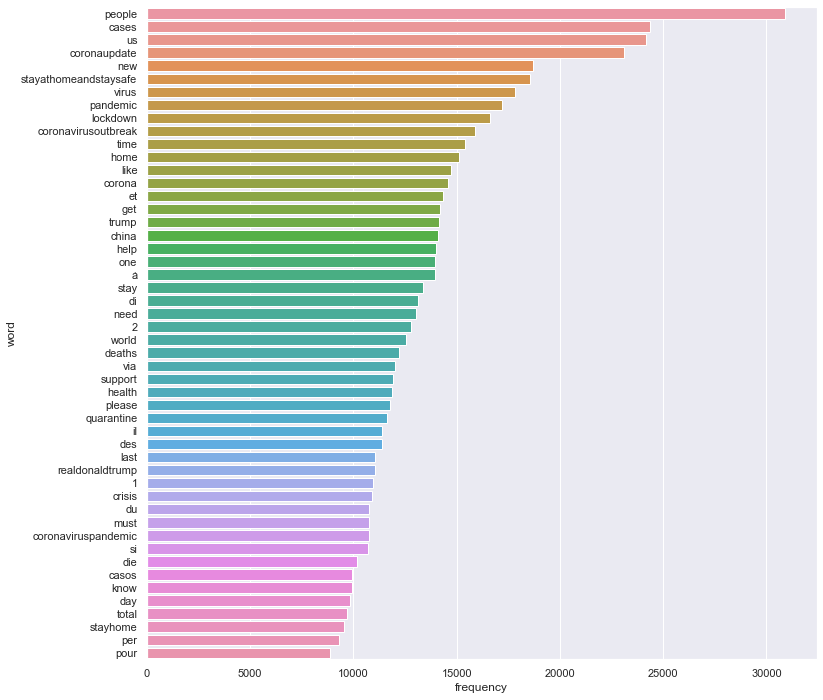

In [21]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')

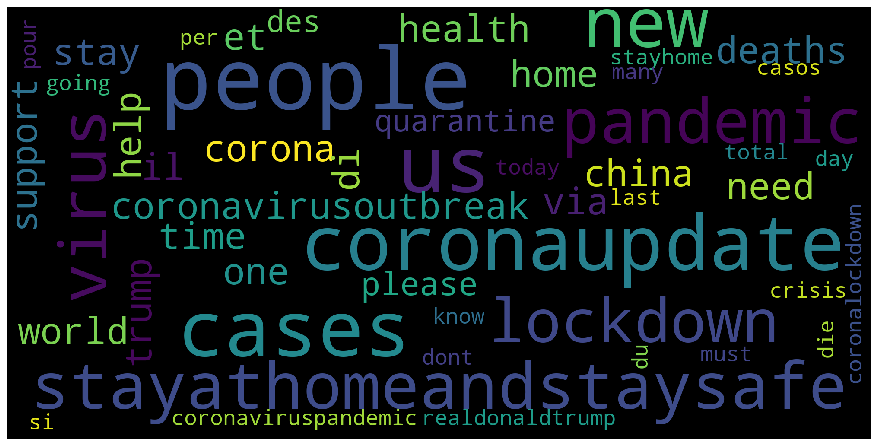

In [22]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')


# polarity scores

In [23]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()

,neg,neu,pos,compound
564136,0.000,0.660,0.340,0.5574
564137,0.000,0.741,0.259,0.7717
564138,0.123,0.739,0.138,0.0772
564139,0.000,1.000,0.000,0.0000
564140,0.268,0.732,0.000,-0.7650


# Classifying the scores based on the compound polarity value

In [24]:
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

,neg,neu,pos,compound,val
0,0.000,1.000,0.0,0.0000,neutral
1,0.000,1.000,0.0,0.0000,neutral
2,0.072,0.928,0.0,-0.1027,negative
3,0.000,1.000,0.0,0.0000,neutral
4,0.000,1.000,0.0,0.0000,neutral


# plotting the sentiment scores

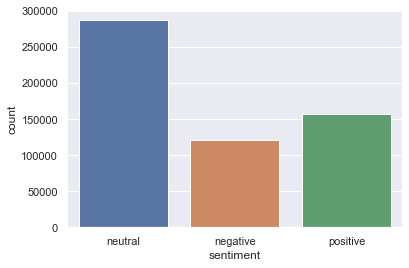

In [25]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')


# sentiment distribution

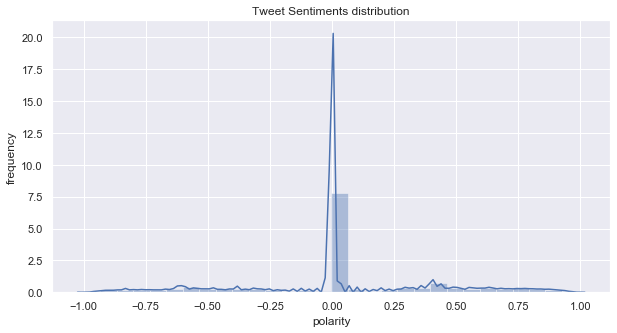

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title='Tweet Sentiments distribution', xlabel='polarity', ylabel='frequency')
sns.distplot(sentiments_time_df['polarity'], bins=30, ax=ax)
# plt.show()
plt.savefig('sentiment_distribution.png')

# popular words from the tweets

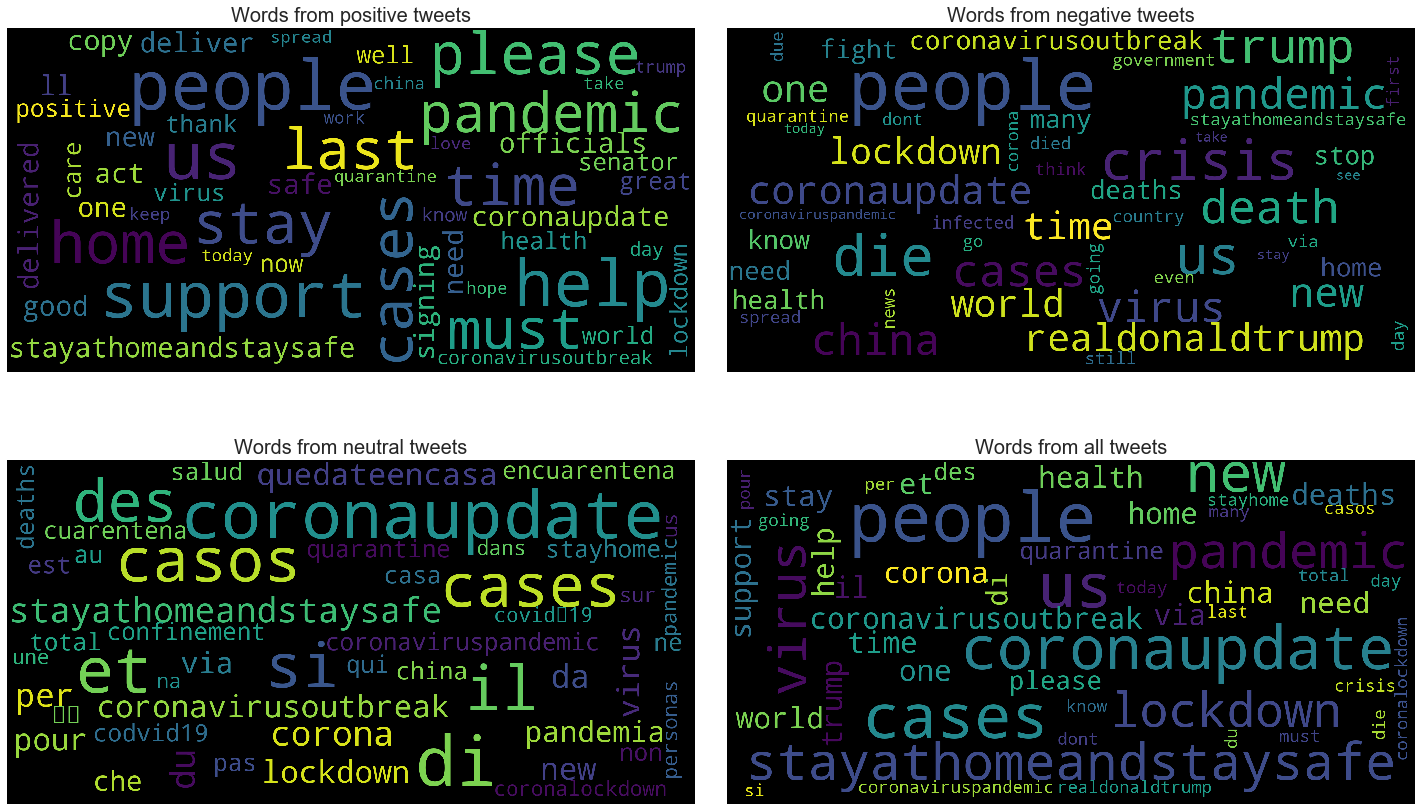

In [30]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))

polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)

axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')
# axs[1, 0].tight_layout(pad = 1)


axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')